# Regional Effects Introduction

This guide provides a gentle overview of Regional Effect methods and introduces the `Effector` package. Regional Effects serve as a bridge between local and global feature effects. Recently, [REPID](https://proceedings.mlr.press/v151/herbinger22a/herbinger22a.pdf) introduced a method to identify regions within the feature space that minimize feature interactions. Their approach focused on minimizing the interaction-related heterogeneity using ICE curves for a singular feature of interest. This methodology has been expanded to encompass ALE and SHAP Dependence Plots for multiple features of interest through [GADGET](https://arxiv.org/pdf/2306.00541.pdf).

In this tutorial, we demonstrate how to leverage `Effector` to pinpoint regions that minimize feature interactions. First, we show how to identify these regions based on ICE curves, as in [REPID](https://proceedings.mlr.press/v151/herbinger22a/herbinger22a.pdf). Then, we illustrate the same procedure based on the heterogeneity of (RH)ALE plots. The former is achieved using the `RegionalPDP` class, while the latter with the `RegionalRHALE` class.

Future releases of `Effector` will include support for `RegionalSHAP` and expand the algorithms for multiple features of interest, as demonstrated in [GADGET](https://arxiv.org/pdf/2306.00541.pdf).

The tutorial is organized as follows:

- Introduction of the simulation example: We explore a simple linear scenario with subgroup-specific feature interactions, defined with both independent and dependent features.
- Modeling: We train a neural network on two datasets, one uncorrelated and the other correlated.
- PDP: Examining the influence of feature interactions and correlations.
- RHALE: Analyzing the impact of feature interactions and correlations.
- Regional Effects: Delving into RegionalPDP and RegionalALE.



In [1]:
import numpy as np
import effector
import keras
import tensorflow as tf

np.random.seed(12345)
tf.random.set_seed(12345)

2023-12-18 21:47:32.227454: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 21:47:32.279756: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 21:47:32.279817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 21:47:32.281290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 21:47:32.290763: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 21:47:32.292741: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Simulation example

We will generate $N=500$ examples with $D=3$ features, which are in the uncorrelated setting all uniformly distributed as follows:

<center>

| Feature | Description                                | Distribution                 |
|-------|------------------------------------------|------------------------------|
| $x_1$   | Uniformly distributed between $-1$ and $1$ | $x_1 \sim \mathcal{U}(-1,1)$ |
| $x_2$   | Uniformly distributed between $-1$ and $1$ | $x_2 \sim \mathcal{U}(-1,1)$ |
| $x_3$   | Uniformly distributed between $-1$ and $1$ | $x_3 \sim \mathcal{U}(-1,1)$ |

</center>

For the correlated setting we keep the distributional assumptions for $x_2$ and $x_3$ but define $x_1$ such that it is highly correlated with $x_3$ by: $x_1 = x_3 + \delta$ with $\delta \sim \mathcal{N}(0,0.0625)$.

In [2]:
def generate_dataset_uncorrelated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = np.random.uniform(-1, 1, size=N)
    return np.stack((x1, x2, x3), axis=-1)

def generate_dataset_correlated(N):
    x3 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x1 = x3 + np.random.normal(loc = np.zeros_like(x3), scale = 0.25)
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset for the uncorrelated and correlated setting
N = 500
X_uncor_train = generate_dataset_uncorrelated(N)
X_uncor_test = generate_dataset_uncorrelated(10000)
X_cor_train = generate_dataset_correlated(N)
X_cor_test = generate_dataset_correlated(10000)

We will use the following linear model with a subgroup-specific interaction term, $y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq0} + x_3 + \epsilon$ with $\epsilon \sim \mathcal{N}(0, 0.09)$. On a global level, there is a high heterogeneity for the features $x_1$ and $x_3$ due to their interaction with each other. However, this heterogeneity vanishes to 0 if the feature space is separated into two regions with respect to $x_3 = 0$. In this case only main effects remain in the two regions: 

<center>

| Feature |Region | Average Effect | Heterogeneity |
| --- | --- | --- |--- |
| $x_1$ | $x_3>0$| $3x_1$ | 0 |
| $x_1$ | $x_3\leq 0$| $-3x_1$ | 0 |
| $x_3$ | $x_3>0$| $x_3$ | 0 |
| $x_3$ | $x_3\leq 0$| $x_3$ | 0 |

</center>

Since $x_2$ does not have any influence (neither main nor interaction effect) on the target, the average effect and the heterogeneity of this feature are $0$ (globally and regionally).
Note that the average effect of $x_1$ cancels out on a global level and thus only considering the average global effect would suggest no influence of the feature on the target.

In [3]:
def generate_target(X):
    f = np.where(X[:,2] > 0, 3*X[:,0] + X[:,2], -3*X[:,0] + X[:,2])
    epsilon = np.random.normal(loc = np.zeros_like(X[:,0]), scale = 0.3)
    Y = f + epsilon
    return(Y)

# generate target for uncorrelated and correlated setting
Y_uncor_train = generate_target(X_uncor_train)
Y_uncor_test = generate_target(X_uncor_test)
Y_cor_train = generate_target(X_cor_train)
Y_cor_test = generate_target(X_cor_test)      

## Fit a Neural Network

We create a two-layer feedforward Neural Network, a weight decay of 0.01 for 100 epochs. We train two instances of this NN, one on the uncorrelated and one on the correlated setting. In both cases, the NN achieves a Mean Squared Error of about $0.17$ units.

In [4]:
# Train - Evaluate - Explain a neural network
model_uncor = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_uncor.compile(optimizer=optimizer, loss="mse")
model_uncor.fit(X_uncor_train, Y_uncor_train, epochs=100)
model_uncor.evaluate(X_uncor_test, Y_uncor_test)

Epoch 1/100


2023-12-18 21:47:34.507540: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


16/16 [==============================] - 1s 4ms/step - loss: 3.0765
Epoch 2/100
16/16 [==============================] - 0s 1ms/step - loss: 2.3938
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 1.8531
Epoch 4/100
16/16 [==============================] - 0s 1ms/step - loss: 1.5445
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 1.1807
Epoch 6/100
16/16 [==============================] - 0s 1ms/step - loss: 0.8460
Epoch 7/100
16/16 [==============================] - 0s 1ms/step - loss: 0.5632
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4551
Epoch 9/100
16/16 [==============================] - 0s 1ms/step - loss: 0.4002
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3639
Epoch 11/100
16/16 [==============================] - 0s 998us/step - loss: 0.3397
Epoch 12/100
16/16 [==============================] - 0s 1ms/step - loss: 0.3221
Epoch 13/100
16/16 [===========================

0.18341386318206787

In [5]:
model_cor = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_cor.compile(optimizer=optimizer, loss="mse")
model_cor.fit(X_cor_train, Y_cor_train, epochs=100)
model_cor.evaluate(X_cor_test, Y_cor_test)

Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 1.8677
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6703
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3194
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2389
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2072
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2013
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.1865
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.1749
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1720
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.1685
Epoch 11/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1656
Epoch 12/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1608
Epoch 13/100
16/16 [=================

0.146001935005188

---
## PDP - Influence of feature interactions and feature correlations



Let' s estimate some notation for the rest of the tutorial:

<center>

| Symbol                                                     | Description                                             |
|------------------------------------------------------------|---------------------------------------------------------|
| $f(\mathbf{x})$                                            | The black box model                                     |
| $x_s$                                                      | The feature of interest                                 |
| $x_c$                                                      | The remaining features, i.e., $\mathbf{x} = (x_s, x_c)$ |
| $\mathbf{x} = (x_s, x_c) = (x_1, x_2, ..., x_s, ..., x_D)$ | The input features                                      |
| $\mathbf{x}^{(i)} = (x_s^{(i)}, x_c^{(i)})$                | The $i$-th instance of the dataset                      |

The PDP is defined as **_the average of the model's prediction over the entire dataset, while varying the feature of interest._**
PDP is defined as 

$$ \text{PDP}(x_s) = \mathbb{E}_{x_c}[f(x_s, x_c)] $$ 

and is approximated by 

$$ \hat{\text{PDP}}(x_s) = \frac{1}{N} \sum_{j=1}^N f(x_s, x^{(i)}_c) $$

Therfore, the PDP is an verage over the underlying ICE curves (local effects) which visualize how the feature of interest influences the prediction of the ML model for each single instance. Heterogeneous ICE curves indicate feature interactions. Therefore, we are expecting heterogeneous ICE curves for $x_1$ and $x_3$ for our uncorrelated simulation example, which can be explained by the underlying feature interactions.

Let's check it out the PDP effect using `effector`.

### Uncorrelated setting

#### Global PDP

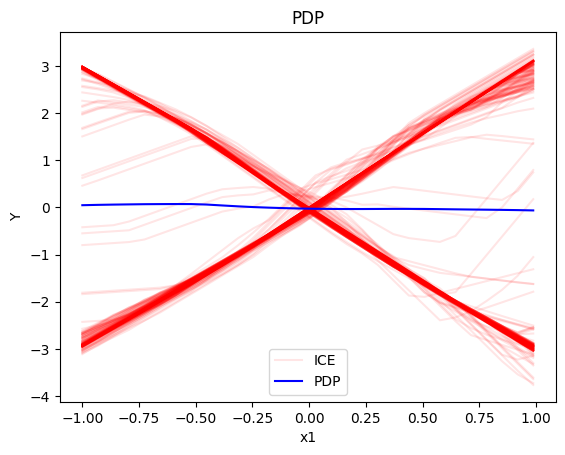

TypeError: cannot unpack non-iterable NoneType object

In [6]:
pdp = effector.PDP(data=X_uncor_train, model=model_uncor, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice")
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice")
fig, ax = pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice")

In the uncorrelated setting $x_1$ has - as expected - an average global feature effect of $0$ while the heteroeneous ICE curves indicate the underlying feature interactions with $x_3$. Also $x_3$ demonstrates a high heterogeneity of local effects due to the interactions with $x_1$ while the average global effect is $x_3$. $x_2$ varies as expected around $0$ with almost zero heterogeneity (note the difference in the scale of the y-axis).

The above are as expected:

* For $x_1$, we have two opposite linear effects that cancel out
  * when $x_3>0$ it is $3x_1$ 
  * when $x_3 \leq 0$, it is $-3x_1$
* For $x_2$ the effect is zero with almost zero heterogeneity (ice curves that deviate are due to bad fitting of the NN)
* For $x_3$, there is a change in the offset:
  * when $x_1>0$ the line is $x_3 - 3x_1^i$ when $x_3 \leq 0$ and $x_3 + 3x_1^i$ when $x_3 > 0$
  * when $x_1<0$ the line is $x_3 + 3x_1^i$ when $x_3 \leq 0$ and $x_3 - 3x_1^i$ when $x_3 > 0$

#### RegionalPDP

Regional PDP will search for interpretable and distinct regions within the feature space such that the interaction-related heterogeneity is minimized within the regions. In the case of PDPs and ICE this means, that we minimize the heterogeneity of mean-centered ICE curves. This means that we group ICE curves with a similar shape, i.e., we find regions in which the instances within this regions show a similar influence on the prediction for the feature of interests, while this influence differs for other regions.

In [ ]:
regional_pdp = effector.RegionalPDP(data=X_uncor_train, model=model_uncor, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)

regional_pdp.fit(
    features="all",
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.3,
    max_split_levels=2,
    nof_candidate_splits_for_numerical=5,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
)

In [ ]:
regional_pdp.describe_subregions(features=0, only_important=True)

In [ ]:
regional_pdp.plot_first_level(feature=0, heterogeneity="ice")

In [ ]:
regional_pdp.describe_subregions(features=1, only_important=True)

In [ ]:
regional_pdp.describe_subregions(features=2, only_important=True)

In [ ]:
regional_pdp.plot_first_level(feature=2, heterogeneity="ice", centering=True)

As expected:

* The subregions of both $x_1$ and $x_3$ are meaningful and $x_2$ should not be split.
* For $x_1$, we have two opposite gradients ($3x_1$ vs $-3x_1$)
* For $x_3$, there is a change in the offset:
  * when $x_1>0$ the line is $x_3 - 3x_1^i$ in the first half and $x_3 + 3x_1^i$ later
  * when $x_1<0$ the line is $x_3 + 3x_1^i$ in the first half and $x_3 - 3x_1^i$ later

### Correlated setting

Since the PDP assumes feature independence, we can observe in the highly correlated setting the following artifact: $x_1$ and $x_3$ are highly positively correlated, therefore, the combination of small (high) $x_1$ and high (small) $x_3$ feature values is not avaiable and thus has not been seen by the model during the training process. However, ICE curves and PDPs are visualized for the entire feature range of the feature of interest (e.g., $x_1$). Thus, we extrapolate with our model (here NN) into unseen or sparse regions of the feature space. This might lead to an osciliating behavior depending on the underlying chosen ML model. Therefore, we might receive heterogeneity of local effects (ICE curves) which are not caused by feature interactions but by extrapolation due to feature correlations. This behavior is especially visible for feature $x_1$ in our example.

In this setup, due to $x_3$ being close to $x_1$, we expect:

   * the effect of $x_1$ will be $-3x_1$ when $x_1 \leq 0$ and $3x_1$ when $x_1 >0$
   * the effect of $x_2$ remains zero
   * the effect of $x_3$ will be $x_3$
   
However, we should mention that this is just a hypothesis. Since the NN learns everything from the data and given that $x_3 \approx x_1$, the NN can learn the mapping $y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq 0} + x_3 + \epsilon = 3x_1I_{x_1>0} - 3x_1I_{x_1\leq 0} + x_1 + \epsilon$, which attributes all the effect of the mapping to $x_1$.

#### Global PDP

In [ ]:
pdp = effector.PDP(data=X_cor_train, model=model_cor, feature_names=['x1','x2','x3'], target_name="Y")
fig, ax = pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice")
fig, ax = pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice")
fig, ax = pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice")

We observed that the global effects are as expected:

   * the effect of $x_1$ will be $-3x_1$ when $x_1 \leq 0$ and $3x_1$ when $x_1 >0$
   * the effect of $x_2$ remains zero
   * the effect of $x_3$ will be $x_3$
   
However, we should notice that there is some heterogeneity, erroneously introduced by extrapolation to unobserved regions:

   * the ICE effects of $x_1$ have different offsets ($\pm$ in the $y$ axis) and different changing points between $-3x_1$ and $3x_1$ (the change does not always happens at $x_1=0$)
   * the ICE effects of $x_3$ create two different groups; one with positive and one with negative gradient

#### Regional-PDP

In [ ]:
regional_pdp = effector.RegionalPDP(
    data=X_cor_train, 
    model=model_cor, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T)

regional_pdp.fit(
    features="all",
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.5,
    max_split_levels=2,
    nof_candidate_splits_for_numerical=5,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
)

In [ ]:
regional_pdp.describe_subregions(features=0, only_important=True)

In [ ]:
regional_pdp.plot_first_level(feature=0, heterogeneity="ice")

In [ ]:
regional_pdp.describe_subregions(features=1, only_important=True)

In [ ]:
regional_pdp.describe_subregions(features=2, only_important=True)

Add some comments

## ALE - Influence of feature interactions and feature correlations




In [ ]:
def model_uncor_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model_uncor(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_cor_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model_cor(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

In [ ]:
rhale = effector.RHALE(data=X_uncor_train, model=model_uncor, model_jac=model_uncor_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.binning_methods.Fixed(15, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False)
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False)
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False)

Add some comments

In [ ]:
regional_rhale = effector.RegionalRHALE(
    data=X_uncor_train, 
    model=model_uncor, 
    model_jac= model_uncor_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.binning_methods.Fixed(10, min_points_per_bin=0)
regional_rhale.fit(
    features="all",
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.3,
    max_split_levels=2,
    nof_candidate_splits_for_numerical=5,
    binning_method=binning_method,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
)


In [ ]:
regional_rhale.describe_subregions(features=0, only_important=True)

In [ ]:
regional_rhale.plot_first_level(
    feature=0, 
    heterogeneity=True, 
    binning_method=binning_method)

In [ ]:
regional_rhale.describe_subregions(features=1, only_important=True)

In [ ]:
regional_rhale.describe_subregions(features=2, only_important=True)

add comments: Eveything makes sense! 

## Correlated setting

In [ ]:
rhale = effector.RHALE(data=X_cor_train, model=model_cor, model_jac=model_cor_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.binning_methods.Fixed(20, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

In [ ]:
rhale.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="std")

In [ ]:
rhale.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="std")

In [ ]:
rhale.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="std")

In [ ]:
regional_rhale = effector.RegionalRHALE(
    data=X_cor_train, 
    model=model_cor, 
    model_jac= model_cor_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T)

In [ ]:
binning_method = effector.binning_methods.Greedy(100, min_points_per_bin=10)
regional_rhale.fit(
    features="all",
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.3,
    max_split_levels=2,
    nof_candidate_splits_for_numerical=5,
    binning_method=binning_method,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
)

In [ ]:
regional_rhale.describe_subregions(features=0, only_important=True)

In [ ]:
regional_rhale.describe_subregions(features=1, only_important=True)

In [ ]:
regional_rhale.describe_subregions(features=2, only_important=True)

add comment, I think the absence of subregions is meaningful 